In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import lsqlin
from scipy import stats
import copy 
from sklearn import svm
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

In [2]:
vix_df = pd.read_excel( 'VIXfutures_20080414_20201231.xlsx' )

vix_df = vix_df.sort_values( by = ['Date'], ascending = True )

x_df = vix_df[ [ 'Date', 'VIX', 'w', \
                       'CMF30', 'CMF60', 'CMF90', 'CMF120', 'CMF150', \
                       'roll30', 'roll60', 'roll90', 'roll120', 'roll150', \
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9' ] ]

# for eache row, if it contains a non-number element in a column, then drop the entire row
x_df = x_df.dropna()

# for eache row, if it contains a 0 element in a column, then drop the entire row
#x_df = x_df.loc[ ( x_df != 0 ).all( axis = 1 ) ]

# reset the index
x_df= x_df.reset_index( drop = True )

dates = x_df[ 'Date' ]

In [3]:
vix = x_df.VIX 
T = len(vix)

v_1 = x_df.CMF30 
v_2 = x_df.CMF60 
v_3 = x_df.CMF90 
v_4 = x_df.CMF120 
v_5 = x_df.CMF150 

d_theta_log_v_1 = x_df.roll30 
d_theta_log_v_2 = x_df.roll60 
d_theta_log_v_3 = x_df.roll90 
d_theta_log_v_4 = x_df.roll120 
d_theta_log_v_5 = x_df.roll150 

In [4]:
vix_etn_number = 10
x_row = vix_etn_number + 1  #  plus 1 here is for the VIX
x_column = len( v_1 );
X = np.ones( ( x_row, x_column ) )

X[ 0, : ] =  np.log( vix )

X[ 1, : ] =  np.log( v_1 )
X[ 2, : ] =  np.log( v_2 )
X[ 3, : ] =  np.log( v_3 )
X[ 4, : ] =  np.log( v_4 )
X[ 5, : ] =  np.log( v_5 )

X[ 6, : ] = d_theta_log_v_1
X[ 7, : ] = d_theta_log_v_2
X[ 8, : ] = d_theta_log_v_3
X[ 9, : ] = d_theta_log_v_4
X[ 10, : ] = d_theta_log_v_5

In [5]:
#######################################################
####
#### 1-month and 5-month rolling futures portfolios
####
#######################################################

dt = 1/252;
r = .03
vxx = np.zeros(T)
vxz = np.zeros(T)
vxx[0]=100
vxz[0]=100
for t in range(T-1):
    vxx[t+1] = vxx[t]*(1+r*dt + X[ 6, t+1 ]*dt  + (X[ 1, t+1 ]-X[ 1, t ])/X[ 1, t ]  )
    vxz[t+1] = vxz[t]*(1+r*dt + X[ 10, t+1 ]*dt  + (X[ 5, t+1 ]-X[ 5, t ])/X[ 5, t ]  )
    
r_trade = -np.diff(vxx)/vxx[:-1] + 2*np.diff(vxz)/vxz[:-1] 

sign_trade = .5*(np.sign(r_trade)+1) ### sign of returns, to be predicted by classifier


In [6]:
#######################################################
####
#### divide data into training and testing
####
#######################################################

T_train = int(np.round(T/2))
ind_train = np.arange(0,T_train  )
X_train = X[:,ind_train]
y_train = sign_trade[ind_train]

ind_test = np.arange(T_train ,T-1)
X_test = X[:,ind_test]
y_test = sign_trade[ind_test]


In [7]:
#######################################################
####
#### build and train a support vector machine
####
#######################################################

classifier = svm.SVC( kernel = 'linear', probability = True) 
y_score = classifier.fit( X_train.T, y_train ).decision_function(X_train.T)
y_predict = classifier.predict( X_train.T )


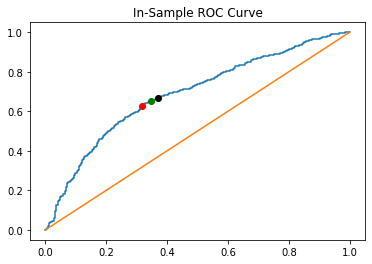

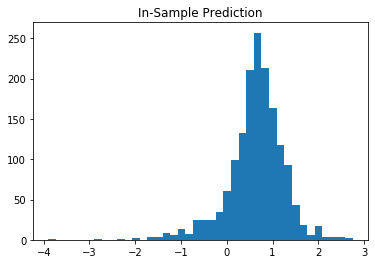

In [8]:
#######################################################
####
#### in-sample ROC curve to determine trading signal
####
#######################################################

fpr = dict()
tpr = dict()
threshold = dict()
roc_auc = dict()

non_nan_index = []
  
fpr, tpr, threshold = roc_curve( y_train, y_score )
roc_auc = auc( fpr, tpr )

#### median, mean and optimal points on ROC curve
ind_med = np.argmin(np.abs(threshold-np.median(y_score)))
ind_mean = np.argmin(np.abs(threshold-np.mean(y_score)))
ind_opt = np.argmin(np.abs(tpr - (1-fpr) ))

plt.plot(fpr,tpr)
plt.plot(fpr,fpr);
plt.plot(fpr[ind_med],tpr[ind_med],'ro') 
plt.plot(fpr[ind_mean],tpr[ind_mean],'ko'); 
plt.plot(fpr[ind_opt],tpr[ind_opt],'go'); 
plt.title('In-Sample ROC Curve');
plt.show()

plt.title('In-Sample Prediction');
plt.hist(y_score,40);

/usr/local/Cellar/jupyterlab/1.2.3/libexec/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


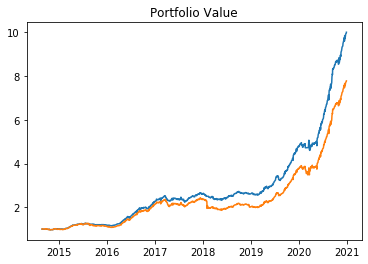

In [9]:
#######################################################
####
#### out-of-sample portfolio using trading signal
####
#######################################################

my_cutoff = threshold[ind_opt] #### this is trading signal 

y_score = classifier.predict(X_test.T).ravel()
my_predict = (np.sign(y_score-my_cutoff)+1)/2

r_my_trade = my_predict*(r_trade[ind_test]) +(1-my_predict)*r*dt
p_my_trade = np.exp(np.cumsum(np.log(1+r_my_trade)))
p_trade = np.exp(np.cumsum(np.log(1+r_trade[ind_test])))

plt.plot(dates[ind_test],p_my_trade);
plt.plot(dates[ind_test],p_trade);
plt.title('Portfolio Value');

my return rate:  0.3627068560543929
(-1,2) return rate:  0.323084094815226


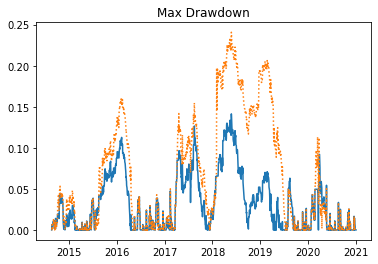

In [10]:
#######################################################
####
#### out-of-sample portfolio return rates and max drawdowns
####
#######################################################

print('my return rate: ',np.log(p_my_trade[-1])/(len(ind_test)*dt))
print('(-1,2) return rate: ',np.log(p_trade[-1])/(len(ind_test)*dt))

p_my_trade_discount = p_my_trade*np.exp(-r*dt*np.arange(len(ind_test)))
p_trade_discount = p_trade*np.exp(-r*dt*np.arange(len(ind_test)))
                                        
my_dd = 1-p_my_trade_discount/np.maximum.accumulate(p_my_trade_discount)
dd = 1-p_trade_discount/np.maximum.accumulate(p_trade_discount)

plt.plot(dates[ind_test],my_dd)
plt.plot(dates[ind_test],dd,':');
plt.title('Max Drawdown');